In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import matplotlib.image as mpimg

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau 


# Original dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -q /content/drive/MyDrive/DATASET/Weekly_Project_8/VND_Banknotes_SouthSandwhich_add_handmade.zip -d ./WP8

In [ ]:
data_dir = pathlib.Path('/content/WP8/VND_Banknotes_SouthSandwhich_handmade')

##Prepare ImageDataGenerator

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def generator_augmentation_maker():
  train_gen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.4,
        horizontal_flip=0.2,
        fill_mode='nearest',
        validation_split=0.2)     # IMPORTANT
  
  val_gen = ImageDataGenerator(validation_split=0.2)  # IMPORTANT

  train_generator = train_gen.flow_from_directory(
          data_dir,  
          target_size=(224, 224),  
          batch_size=32,
          class_mode='categorical',
          shuffle=True,
          seed=19,            # IMPORTANT
          subset='training')  # IMPORTANT

  val_generator = val_gen.flow_from_directory(
          data_dir,
          target_size=(224, 224),
          batch_size=32,
          class_mode='categorical',
          shuffle=False,        # IMPORTANT
          seed=19,              # IMPORTANT
          subset='validation')  # IMPORTANT
  return train_generator, val_generator

In [ ]:
train_generator, val_generator = generator_augmentation_maker()

Found 4171 images belonging to 9 classes.
Found 1039 images belonging to 9 classes.


##Build Model

In [ ]:
# base model: DenseNet169
base_model = keras.applications.DenseNet169(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(224, 224, 3),
    include_top=False)

51888128/51877672 [==============================] - 0s 0us/step


###Base model

In [ ]:
base_model.summary()

Model: "densenet169"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                        

In [ ]:
full_model = keras.applications.DenseNet169(
                          weights="imagenet",
                          input_shape=(224, 224, 3), 
                          include_top=True)

full_model.summary()

58556416/58541896 [==============================] - 1s 0us/step
Model: "densenet169"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_2 (ZeroPadding2  (None, 230, 230, 3)  0          ['input_2[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d_2[0][0]']       
                       

### Full model

In [ ]:
# Freeze the base model
base_model.trainable=False

# define model
inputs = keras.Input(shape=(224, 224, 3))
x = keras.applications.densenet.preprocess_input(inputs)
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)
outputs = keras.layers.Dense(9, activation='softmax')(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 densenet169 (Functional)    (None, 7, 7, 1664)        12642880  
                                                                 
 global_average_pooling2d (G  (None, 1664)             0     

###Callback

In [ ]:
earlystopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=1e-3, # "improving" threshold
    patience=10,
    verbose=1,
    restore_best_weights=True)

In [ ]:
reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5)

In [ ]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath="/content/drive/MyDrive/DATASET/Weekly_Project_8/my_model_checkpoint_Den.h5",
                                                 save_weights_only=False, # the whole model (False) or only weights (True) 
                                                 save_best_only=True, # keep the best model with lowest validation loss
                                                 monitor='val_loss',
                                                 verbose=1)

##Train top layer

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

init_epochs = 50
history = model.fit(train_generator, 
                    validation_data=val_generator,
                    epochs=init_epochs,
                    callbacks=[checkpoint_callback, earlystopping_callback, reduceLR],
                    verbose=1)

Epoch 1/50
131/131 [==============================] - ETA: 0s - loss: 1.2816 - accuracy: 0.5987
Epoch 00001: val_loss improved from inf to 0.87649, saving model to /content/drive/MyDrive/DATASET/Weekly_Project_8/my_model_checkpoint_Den.h5
131/131 [==============================] - 122s 794ms/step - loss: 1.2816 - accuracy: 0.5987 - val_loss: 0.8765 - val_accuracy: 0.7305 - lr: 0.0010
Epoch 2/50
131/131 [==============================] - ETA: 0s - loss: 0.4514 - accuracy: 0.8974
Epoch 00002: val_loss improved from 0.87649 to 0.66408, saving model to /content/drive/MyDrive/DATASET/Weekly_Project_8/my_model_checkpoint_Den.h5
131/131 [==============================] - 94s 714ms/step - loss: 0.4514 - accuracy: 0.8974 - val_loss: 0.6641 - val_accuracy: 0.8296 - lr: 0.0010
Epoch 3/50
131/131 [==============================] - ETA: 0s - loss: 0.2755 - accuracy: 0.9427
Epoch 00003: val_loss did not improve from 0.66408
131/131 [==============================] - 91s 694ms/step - loss: 0.2755 - a

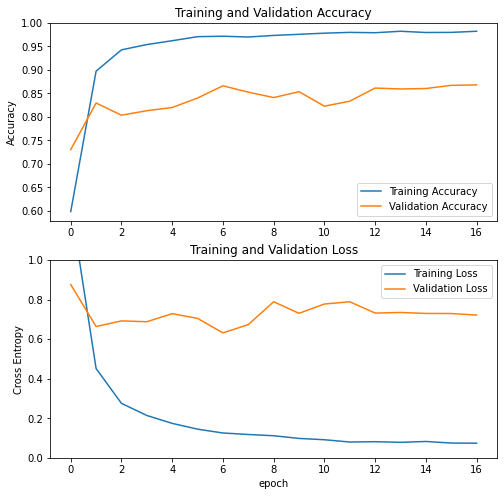

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
model.evaluate(val_generator)

33/33 [==============================] - 8s 253ms/step - loss: 0.6319 - accuracy: 0.8662


[0.6319494247436523, 0.8662174940109253]

## Fine tuning

In [ ]:
restored_model = tf.keras.models.load_model('/content/drive/MyDrive/DATASET/Weekly_Project_8/my_model_checkpoint_Den_new.h5')
restored_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 densenet169 (Functional)    (None, 7, 7, 1664)        12642880  
                                                                 
 global_average_pooling2d (G  (None, 1664)             0     

In [ ]:
restored_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
earlystopping_callback_2 = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=1e-5, # "improving" threshold
    patience=50,
    verbose=1,
    restore_best_weights=True)

In [ ]:
reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5)

In [ ]:
checkpoint_callback_2 = tf.keras.callbacks.ModelCheckpoint(filepath="/content/drive/MyDrive/DATASET/Weekly_Project_8/my_model_checkpoint_Den.h5",
                                                 save_weights_only=False, # the whole model (False) or only weights (True) 
                                                 save_best_only=True, # keep the best model with lowest validation loss
                                                 monitor='val_loss',
                                                 verbose=1)

In [ ]:
init_epochs = 100

history = restored_model.fit(train_generator, 
                    validation_data=val_generator,
                    epochs=init_epochs,
                    callbacks=[checkpoint_callback_2, earlystopping_callback_2, reduceLR],
                    verbose=1)


Epoch 1/100
131/131 [==============================] - ETA: 0s - loss: 0.1351 - accuracy: 0.9619
Epoch 00001: val_loss did not improve from 0.65112
131/131 [==============================] - 101s 713ms/step - loss: 0.1351 - accuracy: 0.9619 - val_loss: 0.6926 - val_accuracy: 0.8104 - lr: 1.0000e-04
Epoch 2/100
131/131 [==============================] - ETA: 0s - loss: 0.1370 - accuracy: 0.9633
Epoch 00002: val_loss did not improve from 0.65112
131/131 [==============================] - 91s 698ms/step - loss: 0.1370 - accuracy: 0.9633 - val_loss: 0.6696 - val_accuracy: 0.8191 - lr: 1.0000e-04
Epoch 3/100
131/131 [==============================] - ETA: 0s - loss: 0.1319 - accuracy: 0.9667
Epoch 00003: val_loss did not improve from 0.65112
131/131 [==============================] - 91s 694ms/step - loss: 0.1319 - accuracy: 0.9667 - val_loss: 0.6942 - val_accuracy: 0.8162 - lr: 1.0000e-04
Epoch 4/100
131/131 [==============================] - ETA: 0s - loss: 0.1263 - accuracy: 0.9643
Epoch

In [ ]:
restored_model = tf.keras.models.load_model('/content/drive/MyDrive/DATASET/Weekly_Project_8/my_model_checkpoint_Den_new.h5')
restored_model.evaluate(val_generator)

33/33 [==============================] - 29s 454ms/step - loss: 0.6268 - accuracy: 0.8229


[0.6267661452293396, 0.8229066133499146]

##Predict

In [ ]:
restored_model = tf.keras.models.load_model('/content/drive/MyDrive/DATASET/Weekly_Project_8/my_model_checkpoint_Den.h5')

In [ ]:
restored_model.evaluate(val_generator)

33/33 [==============================] - 16s 367ms/step - loss: 0.6449 - accuracy: 0.8373


[0.6448763608932495, 0.8373435735702515]

In [ ]:
from google.colab import files

# UPLOAD A PHOTO and PREDICT
uploaded = files.upload()
for fn in uploaded.keys():
  print(fn)
  img_path = './' + fn

Saving 500.jpg to 500.jpg
500.jpg


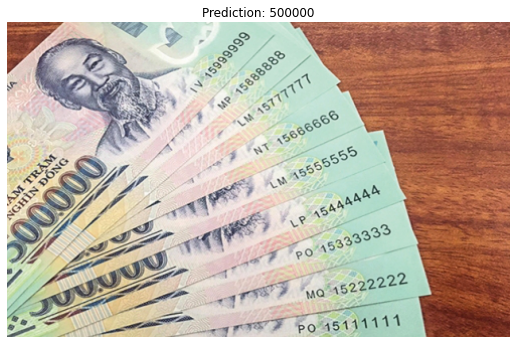

In [ ]:
from keras.preprocessing import image
import matplotlib.image as mpimg

img = image.load_img(img_path, target_size=(224,224,3))
img = image.img_to_array(img)
img = np.expand_dims(img, axis = 0)
prediction = restored_model.predict(img)

for key, value in val_generator.class_indices.items():
  if value == prediction[0].argmax():
    pred = key

plt.figure(figsize=(9, 6))
img = mpimg.imread(img_path)
imgplot = plt.imshow(img)
plt.title('Prediction: ' + pred.upper())
plt.grid(b=None)
plt.axis('off')
plt.show()

In [ ]:

# UPLOAD A PHOTO and PREDICT
uploaded = files.upload()
for fn in uploaded.keys():
  print(fn)
  img_path = './' + fn

Saving 50.JPG to 50 (1).JPG
50.JPG


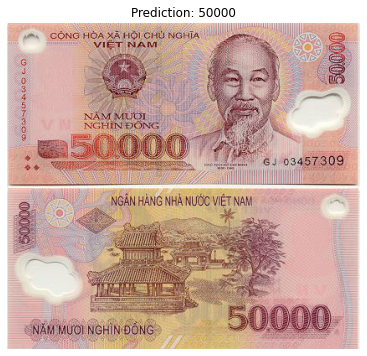

In [ ]:
img = image.load_img(img_path, target_size=(224,224,3))
img = image.img_to_array(img)
img = np.expand_dims(img, axis = 0)
prediction = restored_model.predict(img)

for key, value in val_generator.class_indices.items():
  if value == prediction[0].argmax():
    pred = key

plt.figure(figsize=(9, 6))
img = mpimg.imread(img_path)
imgplot = plt.imshow(img)
plt.title('Prediction: ' + pred.upper())
plt.grid(b=None)
plt.axis('off')
plt.show()

In [ ]:
# UPLOAD A PHOTO and PREDICT
uploaded = files.upload()
for fn in uploaded.keys():
  print(fn)
  img_path = './' + fn

Saving 10K.png to 10K.png
10K.png


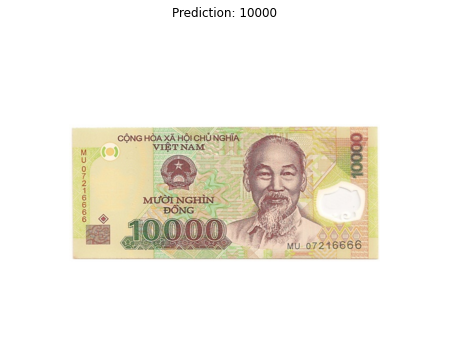

In [ ]:
img = image.load_img(img_path, target_size=(224,224,3))
img = image.img_to_array(img)
img = np.expand_dims(img, axis = 0)
prediction = restored_model.predict(img)

for key, value in val_generator.class_indices.items():
  if value == prediction[0].argmax():
    pred = key

plt.figure(figsize=(9, 6))
img = mpimg.imread(img_path)
imgplot = plt.imshow(img)
plt.title('Prediction: ' + pred.upper())
plt.grid(b=None)
plt.axis('off')
plt.show()

##Model Evaluate

In [ ]:
val_generator.class_indices

{'1000': 0,
 '10000': 1,
 '100000': 2,
 '2000': 3,
 '20000': 4,
 '200000': 5,
 '5000': 6,
 '50000': 7,
 '500000': 8}

In [ ]:
ground_truth = val_generator.classes

In [ ]:
filenames = val_generator.filenames
filenames[:5]

['1000/1024.png',
 '1000/1026.png',
 '1000/1027.png',
 '1000/1043.png',
 '1000/1044.png']

In [ ]:
predictions = restored_model.predict(val_generator)
pred_indices = np.argmax(predictions,axis=1)

img_paths = list(map(lambda x: str(data_dir/x), filenames))  # Full path

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(ground_truth, pred_indices, target_names=list(val_generator.class_indices.keys())))

              precision    recall  f1-score   support

        1000       0.94      0.91      0.93       131
       10000       0.97      0.71      0.82       141
      100000       1.00      0.50      0.67       105
        2000       1.00      1.00      1.00        60
       20000       0.99      0.71      0.83       112
      200000       0.92      0.95      0.93       127
        5000       0.99      0.89      0.94       103
       50000       0.97      0.88      0.92       117
      500000       0.50      0.99      0.66       143

    accuracy                           0.84      1039
   macro avg       0.92      0.84      0.86      1039
weighted avg       0.90      0.84      0.85      1039



## Error Analysis

In [ ]:
filenames = val_generator.filenames
print(len(filenames))
print(filenames[200:205], '\n')

ground_truth = val_generator.classes
print(len(ground_truth))
ground_truth

1039
['10000/134.png', '10000/1342.png', '10000/1345.png', '10000/135.png', '10000/1350.png'] 

1039


array([0, 0, 0, ..., 8, 8, 8], dtype=int32)

In [ ]:
restored_model = tf.keras.models.load_model('/content/drive/MyDrive/DATASET/Weekly_Project_8/my_model_checkpoint_Den.h5')

In [ ]:
predictions = restored_model.predict(val_generator)

In [ ]:
# prediction_table is a dict with index, prediction, ground truth
prediction_table = {}
for index, val in enumerate(predictions):
    # get argmax index
    index_of_highest_probability = np.argmax(val)
    value_of_highest_probability = val[index_of_highest_probability]
    prediction_table[index] = [value_of_highest_probability, 
                               index_of_highest_probability, 
                               ground_truth[index]]
assert len(predictions) == len(ground_truth) == len(prediction_table)

In [ ]:
def get_images_with_sorted_probabilities(prediction_table,
                                         get_highest_probability,
                                         label,
                                         number_of_items,
                                         only_false_predictions=False):
    sorted_prediction_table = [(k, prediction_table[k])
                               for k in sorted(prediction_table,
                                               key=prediction_table.get,
                                               reverse=get_highest_probability)
                               ]
    result = []
    for index, key in enumerate(sorted_prediction_table):
        image_index, [probability, predicted_index, gt] = key
        if predicted_index == label:
            if only_false_predictions == True:
                if predicted_index != gt:
                    result.append(
                        [image_index, [probability, predicted_index, gt]])
            else:
                result.append(
                    [image_index, [probability, predicted_index, gt]])
    return result[:number_of_items]

def plot_images(filenames, distances, message):
    images = []
    for filename in filenames:
        images.append(mpimg.imread(filename))
    plt.figure(figsize=(20, 15))
    columns = 5
    for i, image in enumerate(images):
        ax = plt.subplot(len(images) / columns + 1, columns, i + 1)
        ax.set_title("\n\n" + filenames[i].split("/")[-1] + "\n" +
                     "\nProbability: " +
                     str(float("{0:.2f}".format(distances[i]))))
        plt.suptitle(message, fontsize=20, fontweight='bold')
        plt.axis('off')
        plt.imshow(image)
        
def display(sorted_indices, message):
    similar_image_paths = []
    distances = []
    for name, value in sorted_indices:
        [probability, predicted_index, gt] = value
        similar_image_paths.append(str(data_dir) + '/' + filenames[name])
        distances.append(probability)
    plot_images(similar_image_paths, distances, message)

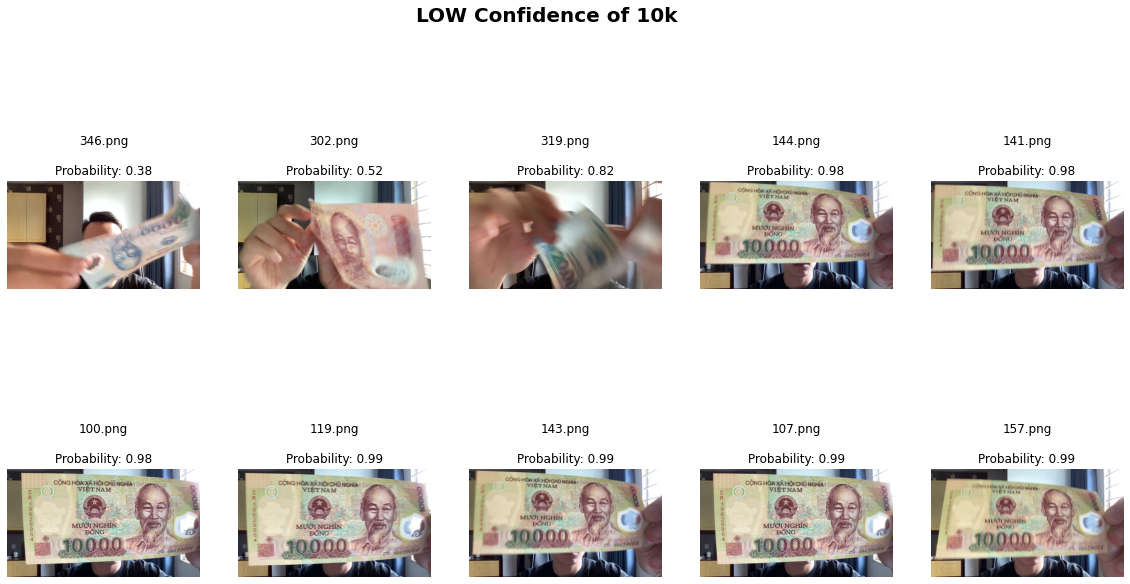

In [ ]:
message = 'LOW Confidence of 10k'
lowest_confident_10k = get_images_with_sorted_probabilities(prediction_table, False, 1, 10, False)
display(lowest_confident_10k, message)

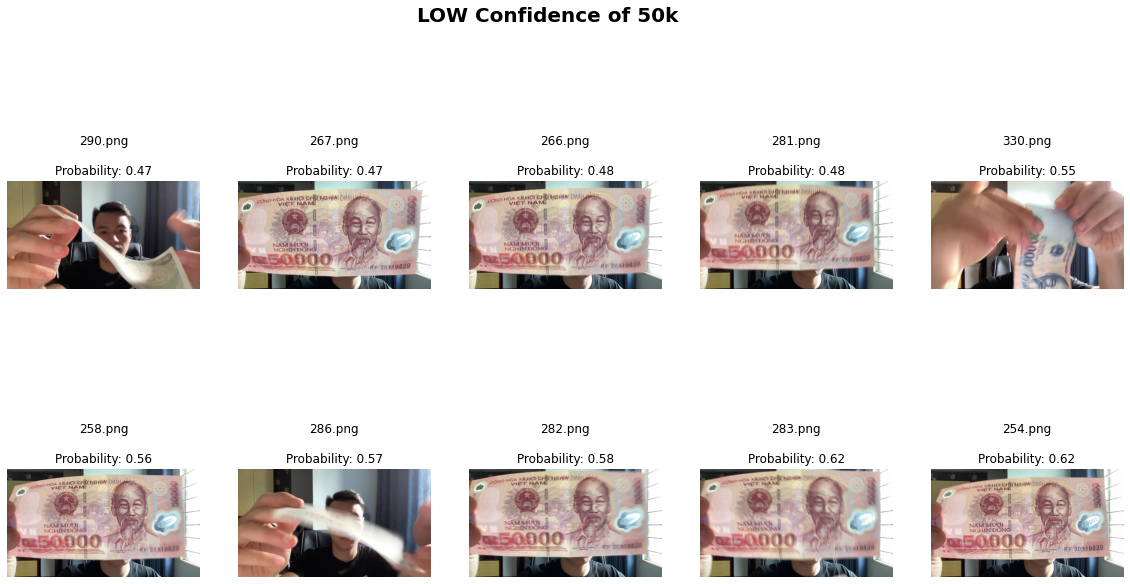

In [ ]:
message = 'LOW Confidence of 50k'
lowest_confident_50k = get_images_with_sorted_probabilities(prediction_table, False, 7, 10, False)
display(lowest_confident_50k, message)

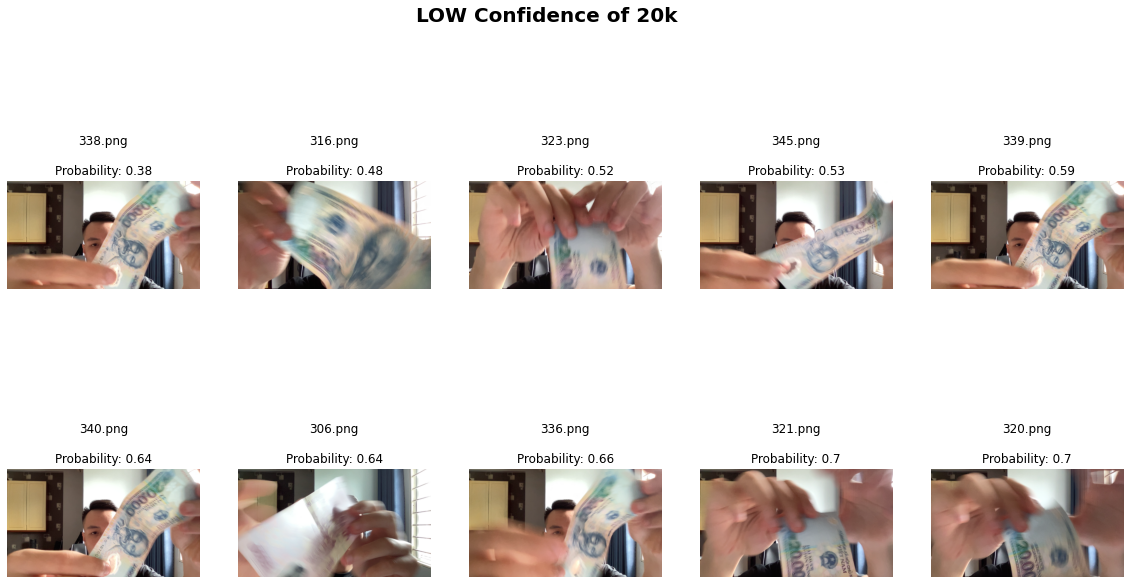

In [ ]:
message = 'LOW Confidence of 20k'
lowest_confident_20k = get_images_with_sorted_probabilities(prediction_table, False, 4, 10, False)
display(lowest_confident_20k, message)

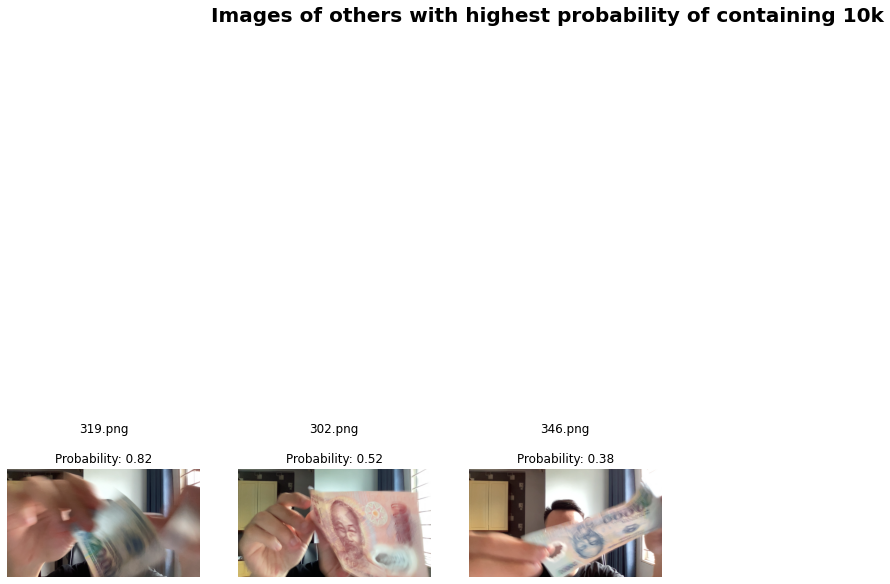

In [ ]:
message = 'Images of others with highest probability of containing 10k'
incorrect_10k = get_images_with_sorted_probabilities(prediction_table, True, 1, 10, True)
display(incorrect_10k, message)

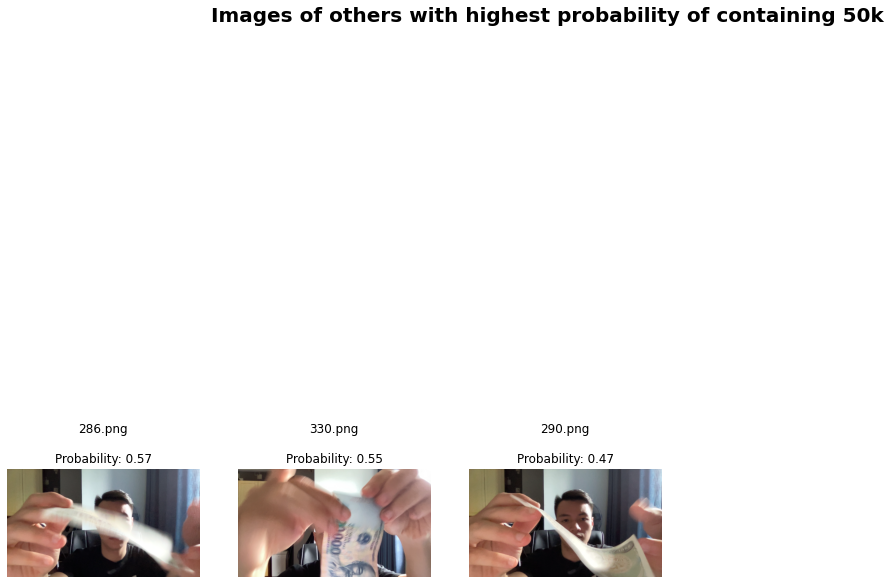

In [ ]:
message = 'Images of others with highest probability of containing 50k'
incorrect_50k = get_images_with_sorted_probabilities(prediction_table, True, 7, 10, True)
display(incorrect_50k, message)

##GradCAM

In [ ]:
# plotting functions
def get_img_array(img_path, img_size):
    # `img` is a PIL image
    img = keras.preprocessing.image.load_img(img_path, target_size=(img_size,img_size)) # load and resize
    array = keras.preprocessing.image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    # array = preprocess_input(array)     # comment this line if model includes a preprocessing layer
    return array

def plot_image_with_pred(img_path, model, labels, img_size=224):
    # display part
    img = Image.open(img_path)
    img =  img.resize((img_size,img_size))   # resize to mimic model's input
    img = np.array(img)
    plt.imshow(img)
    # prediction part
    img_array = get_img_array(img_path, img_size)
    preds = model.predict(img_array)
    plt.title(f'Prediction: {labels[preds.argmax(axis=1)[0]]}, with {round(preds.max()*100,2)}%')
    return img_array

In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, classifier_layer_names, base_model_idx, pretrained=True):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    if pretrained:
        last_conv_layer = model.layers[base_model_idx].get_layer(last_conv_layer_name)
        last_conv_layer_model = keras.Model(model.layers[base_model_idx].inputs, last_conv_layer.output)
    else:
        last_conv_layer = model.get_layer(last_conv_layer_name)
        last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

        
    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    
    for layer_name in classifier_layer_names:
      try:
          x = model.get_layer(layer_name)(x)
      except:
          x = model.layers[base_model_idx].get_layer(layer_name)(x)  
    classifier_model = keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index] # the f function

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

# We load the original image
def plot_with_heatmap(img_path, heatmap, img_size=224):
    img = keras.preprocessing.image.load_img(img_path, target_size=(img_size, img_size))
    img = keras.preprocessing.image.img_to_array(img)

    # We rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # We use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # We use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # We create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap  + img*0.6
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
    
    fig, axes = plt.subplots(2, 1, figsize=(10,10))
    step = img_size//7
    axes[0].set_xticks([x*step for x in range(1,7)])
    axes[0].set_yticks([x*step for x in range(1,7)])
    axes[0].imshow(jet_heatmap.astype(int))
    axes[1].set_xticks([x*step for x in range(1,7)])
    axes[0].set_yticks([x*step for x in range(1,7)])
    axes[1].imshow(superimposed_img)
    

In [ ]:
restored_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 densenet169 (Functional)    (None, 7, 7, 1664)        12642880  
                                                                 
 global_average_pooling2d (G  (None, 1664)             0     

In [ ]:
restored_model.layers[4].summary()

Model: "densenet169"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                        

In [ ]:
base_model_idx = 4  # <<<<<
last_conv_idx = -3  # <<<<<

last_conv_layer_name = restored_model.layers[base_model_idx].layers[last_conv_idx].name # destination layer
the_rest_names = [i.name for i in restored_model.layers[base_model_idx].layers[last_conv_idx+1:]] + [j.name for j in restored_model.layers[(base_model_idx+1):]]

# CHECK
print(last_conv_layer_name, '\n')
print(the_rest_names)

conv5_block32_concat 

['bn', 'relu', 'global_average_pooling2d', 'dropout', 'dense']


In [ ]:
def display_everything(path, last_conv_layer_name, the_rest_names, base_model_idx):
  img_path = path
  
  img_array = plot_image_with_pred(img_path, restored_model,labels=list(train_generator.class_indices.keys()))
  
  heatmap = make_gradcam_heatmap(img_array, restored_model, 
                                last_conv_layer_name, 
                                the_rest_names,
                                base_model_idx)
  
  plot_with_heatmap(img_path,heatmap)

In [ ]:
predictions = restored_model.predict(val_generator)
pred_indices = np.argmax(predictions,axis=1)

ground_truth = val_generator.classes

wrong_pred_paths = np.array(img_paths)[(pred_indices != ground_truth)]

print("Total wrong predictions:", len(wrong_pred_paths), '\n')
wrong_pred_paths

Total wrong predictions: 169 



array(['/content/WP8/VND_Banknotes_SouthSandwhich_handmade/1000/1026.png',
       '/content/WP8/VND_Banknotes_SouthSandwhich_handmade/1000/286.png',
       '/content/WP8/VND_Banknotes_SouthSandwhich_handmade/1000/287.png',
       '/content/WP8/VND_Banknotes_SouthSandwhich_handmade/1000/288.png',
       '/content/WP8/VND_Banknotes_SouthSandwhich_handmade/1000/290.png',
       '/content/WP8/VND_Banknotes_SouthSandwhich_handmade/1000/291.png',
       '/content/WP8/VND_Banknotes_SouthSandwhich_handmade/1000/292.png',
       '/content/WP8/VND_Banknotes_SouthSandwhich_handmade/1000/293.png',
       '/content/WP8/VND_Banknotes_SouthSandwhich_handmade/1000/294.png',
       '/content/WP8/VND_Banknotes_SouthSandwhich_handmade/1000/295.png',
       '/content/WP8/VND_Banknotes_SouthSandwhich_handmade/1000/302.png',
       '/content/WP8/VND_Banknotes_SouthSandwhich_handmade/1000/303.png',
       '/content/WP8/VND_Banknotes_SouthSandwhich_handmade/10000/1222.png',
       '/content/WP8/VND_Banknotes_

In [ ]:
def plot_images(img_paths, message, img_size=224):
    plt.figure(figsize=(20, 20))
    columns = 4
    for i, img_path in enumerate(img_paths):
        # predict
        img_array = get_img_array(img_path, img_size)
        predictions = restored_model.predict(img_array)

        # setup
        ax = plt.subplot(len(img_paths) / columns + 1, columns, i + 1)
        ax.set_title(img_paths[i].split("/")[-1] + "\n" +
                     "\nProbability: " + str(float("{0:.1f}".format(predictions.max()*100))))
        plt.suptitle(message, fontsize=20, fontweight='bold')
        plt.axis('off')
        
        # show
        img = Image.open(img_path)
        img = np.array(img)
        plt.imshow(img)

In [ ]:
import matplotlib.image as mpimg
from PIL import Image

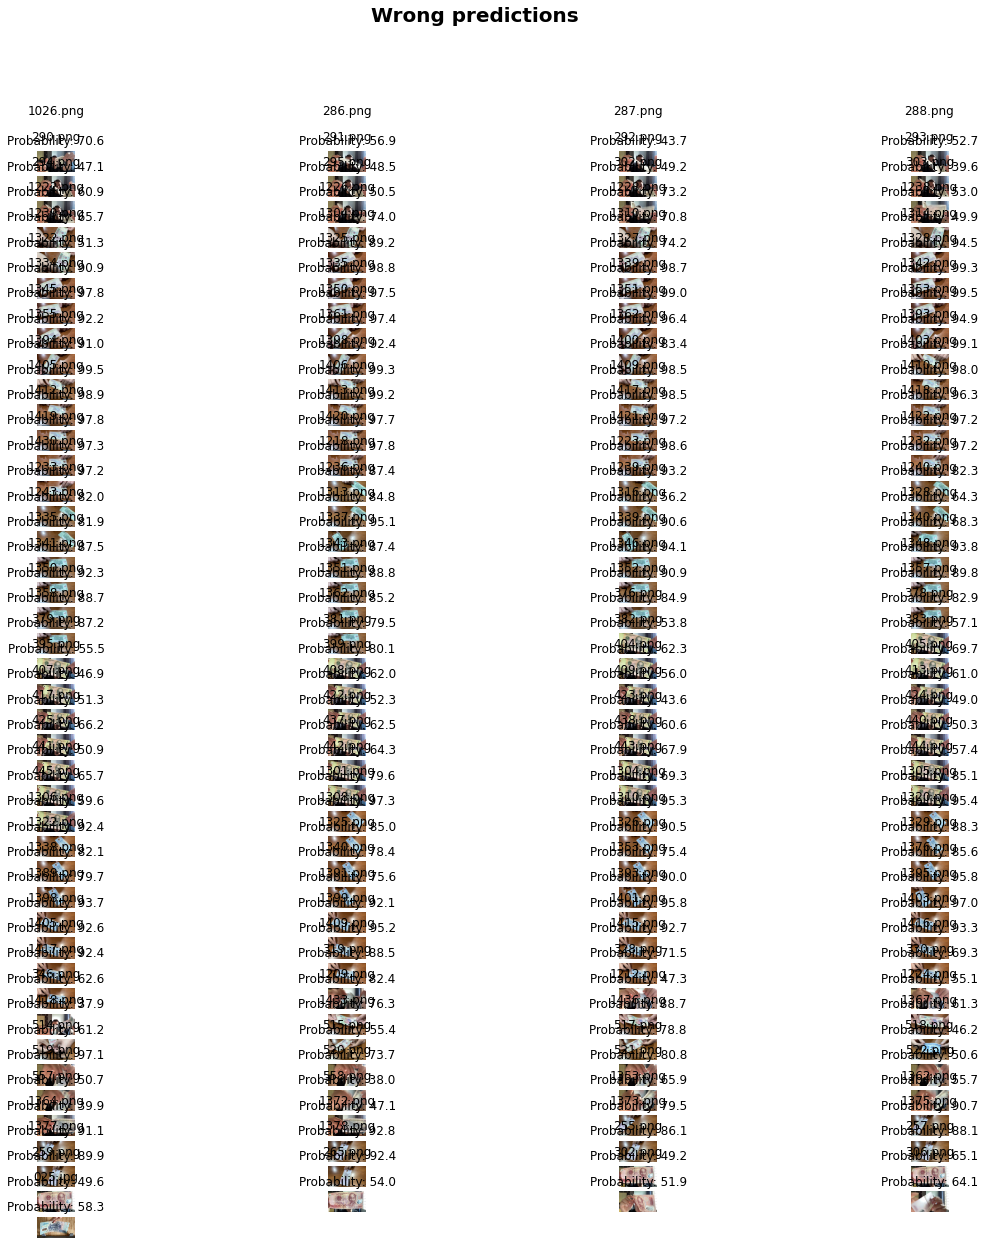

In [ ]:
plot_images(wrong_pred_paths, "Wrong predictions")

In [ ]:
import matplotlib.cm as cm

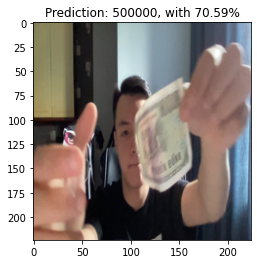

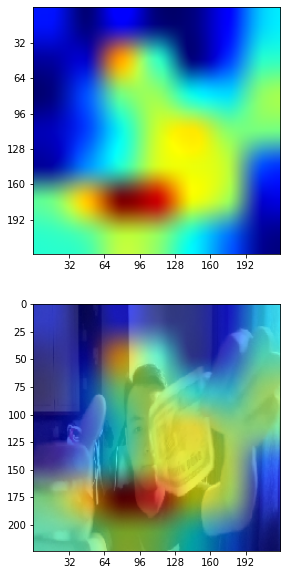

In [ ]:
heatmap = display_everything(wrong_pred_paths[0], last_conv_layer_name, the_rest_names, base_model_idx)

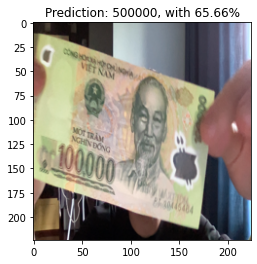

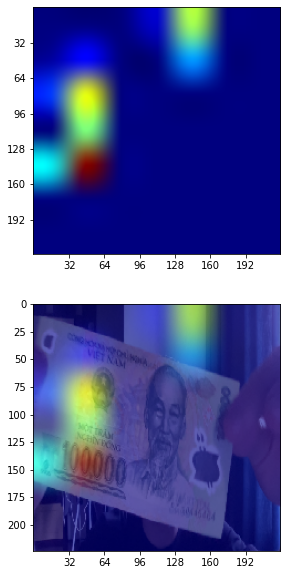

In [ ]:
heatmap = display_everything(wrong_pred_paths[100], last_conv_layer_name, the_rest_names, base_model_idx)

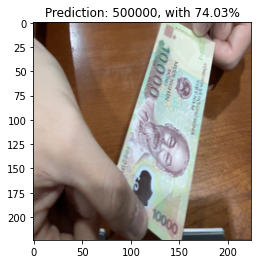

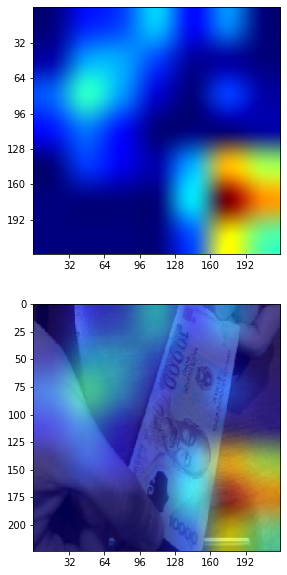

In [ ]:
heatmap = display_everything(wrong_pred_paths[13], last_conv_layer_name, the_rest_names, base_model_idx)